In [1]:
import sys
sys.path.insert(0, '..')

from functools import partial
import matplotlib.pyplot as plt
import pandas as pd
import diaphanous as it

it.show(f'<h1>CyberTipline Reports per Country</h1>')
it.show(f'<h2>Data Schemas</h2>')

logger = partial(it.show, show_schema=True, margin_bottom=2)
country_data = it.ingest_reports_per_country('../data', logger=logger)


index,iso3,:,category,(no nulls)
index,year,:,category,(no nulls)
column,reports,:,int64,(no nulls)
column,reports_pct,:,float64,(no nulls)


index,iso3,:,category,(no nulls)
index,year,:,category,(no nulls)
column,population,:,int64,(no nulls)
column,population_pct,:,float64,(no nulls)


index,iso3,:,category,(no nulls)
index,year,:,category,(no nulls)
column,online,:,int64,(no nulls)
column,online_pct,:,float64,(no nulls)


index,iso3,:,category,(no nulls)
column,country,:,category,(no nulls)
column,iso2,:,category,(no nulls)
column,region,:,category,(no nulls)


index,,:,int64,(no nulls)
column,superregion,:,category,(no nulls)
column,region,:,category,(no nulls)
column,continent,:,category,(no nulls)


index,,:,int64,(no nulls)
column,iso3,:,category,(no nulls)


index,iso3,:,category,(no nulls)
index,year,:,category,(no nulls)
column,reports,:,int64,(no nulls)
column,reports_pct,:,float64,(no nulls)
column,reports_per_capita,:,float64,(no nulls)
column,population,:,int64,(no nulls)
column,population_pct,:,float64,(no nulls)
column,online,:,float64,(872 nulls)
column,online_pct,:,float64,(872 nulls)
column,country,:,category,(no nulls)
column,iso2,:,category,(no nulls)


In [2]:
it.show(f'<h2>Missing Population Data</h2>')
countries_without, reports_without = it.without_populations(
    country_data.reports, country_data.populations, country_data.countries
)
it.show(
    f'{countries_without.shape[0]} countries have reports but not population '
    'statistics. They also account for very few reports:'
)
it.show(
    reports_without,
    caption='Reports for Countries<br>w/o Population Stats',
)
it.show('The countries are:')
it.show(countries_without, caption='Countries without Population Data in UN Dataset')


,reports,reports_pct
year,,
2019,28,0.000165
2020,97,0.000446
2021,243,0.000827
2022,117,0.000365
2023,58,0.000160


,country,region
iso3,,
ALA,Åland Islands,Northern Europe
ANT,Netherlands Antilles,Caribbean
ATA,Antarctica,Antarctica
ATF,French Southern Territories,Eastern Africa
BVT,Bouvet Island,South America
CCK,Cocos (Keeling) Islands,Australia and New Zealand
CXR,Christmas Island,Australia and New Zealand
EEE,Europe,Europe
IOT,British Indian Ocean Territory,Eastern Africa


In [3]:
df = (
    country_data.reports
    .reset_index()
    .pipe(lambda df: df[df['iso3'].isin(countries_without.index) & (df['reports'] > 0)])
    .merge(country_data.countries, how='left', on='iso3')
    [['iso3', 'country', 'year', 'reports', 'reports_pct']]
)
it.show(df, caption='Reports for Countries w/o Population Data', with_index=False)

iso3,country,year,reports,reports_pct
ALA,Åland Islands,2019,15,0.00008830
ALA,Åland Islands,2020,20,0.00009195
ALA,Åland Islands,2021,21,0.00007143
ALA,Åland Islands,2022,51,0.00015908
ALA,Åland Islands,2023,25,0.00006904
ANT,Netherlands Antilles,2019,1,0.00000589
ANT,Netherlands Antilles,2020,10,0.00004597
ANT,Netherlands Antilles,2021,2,0.00000680
ANT,Netherlands Antilles,2022,1,0.00000312
ATA,Antarctica,2019,1,0.00000589


In [4]:
it.show(f'<h2>Reports by Continent</h2>')

# Reduce dataframe to columns of interest
continental_base = country_data.reports_per_capita[['reports_pct', 'continent']]

# Prepare dataframe with reports_pct for Arab League separated by continent
league = (
    continental_base
    .loc[country_data.arab_league['iso3']]
    .groupby(['continent', 'year'])
    .sum(numeric_only=True)
    .drop(['Americas', 'Antarctica', 'Europe', 'Oceania'])
    .unstack(level=0)
)
league.columns = league.columns.droplevel()
league.columns.name = None

# Construct column for USA
usa = (
    continental_base
    .loc['USA']
    .copy()
    .drop(columns='continent')
    ['reports_pct']
)

# Construct table with continental columns
continental = (
    continental_base
    .groupby(['year', 'continent'])
    .sum(numeric_only=True)
    .unstack()
)
continental.columns = continental.columns.droplevel()
continental.columns.name = None

# Subtract USA from Americas and add USA to continental breakdown
continental['Americas'] = continental['Americas'] - usa
continental.insert(2, 'USA', usa)

# Make sure Antarctica accounts for 0% every year before dropping it
for year in range(2019, 2024):
    assert continental.loc[str(year), 'Antarctica'] == 0
continental = continental.drop(columns='Antarctica')

# Reorder
continental = continental[['Americas', 'USA', 'Europe', 'Africa', 'Asia', 'Oceania']]
c2 = continental.copy()
c2['Africa'] = c2['Africa'] - league['Africa']
c2['Asia'] = c2['Asia'] - league['Asia']
c2.insert(4, 'Arab League (Asia)', league['Asia'])
c2.insert(4, 'Arab League (Africa)', league['Africa'])
#c2.insert(4, 'Arab League', league.sum(axis=1))

# Validate that rows sum up to 100% - epsilon
for sum in continental.sum(axis=1).values:
    assert sum > 99.999

it.show(continental, caption='% Reports by Continent, USA Separate')
it.show(c2, caption='% Reports by Continent, USA & Arab League Separate')

,Americas,USA,Europe,Africa,Asia,Oceania
year,,,,,,
2019,12.84,12.89,5.91,10.50,57.6,0.271
2020,16.89,5.22,6.26,14.24,57.2,0.232
2021,9.48,6.50,3.05,10.21,70.4,0.337
2022,11.66,10.06,6.59,7.00,63.9,0.756
2023,8.89,8.24,5.37,8.68,68.5,0.310


,Americas,USA,Europe,Africa,Arab League (Africa),Arab League (Asia),Asia,Oceania
year,,,,,,,,
2019,12.84,12.89,5.91,1.30,9.20,13.65,43.9,0.271
2020,16.89,5.22,6.26,1.73,12.50,10.09,47.1,0.232
2021,9.48,6.50,3.05,1.20,9.01,10.29,60.1,0.337
2022,11.66,10.06,6.59,1.56,5.44,7.41,56.5,0.756
2023,8.89,8.24,5.37,2.18,6.51,7.75,60.8,0.310


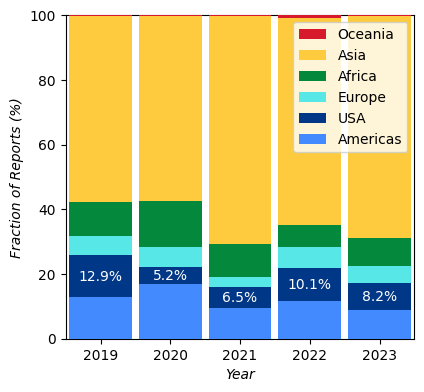

In [5]:
#COLORS1 = ["#d7192c", "#ffca00", "#2e8b57", "#0aa78d", "#1755b5", "#3f86fa"]
COLORS1 = ["#438aff", "#013787", "#58e7e7", "#04883b", "#fdcb3d", "#d7192c"]
#COLORS1 = ['#fb9a99','#e31a1c','#a6cee3','#1f78b4','#fdbf6f','#ff7f00']
COLORS2 = ['#fb9a99','#e31a1c','#a6cee3','#1f78b4','#b2df8a','#33a02c','#fdbf6f','#ff7f00']

def plot(data, ax, colors):
    data.plot.bar(
        ax=ax,
        stacked=True,
        zorder=3,
        width=0.9,
        color = colors,
        figsize=[4.5, 4.2],
    )
    ax.set_xlim(-0.5, 4.5)
    ax.set_xlabel('Year', fontstyle='italic')
    ax.set_ylabel('Fraction of Reports (%)', fontstyle='italic')
    ax.tick_params(axis='x', labelrotation=0)
    ax.set_ylim(top=100)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1])
    #ax.legend(loc=(0.635, 0.4))

    ax.bar_label(
        ax.containers[1],
        labels=[f'{v:.1f}%' for v in usa.values],
        label_type='center',
        color='w',
    )

fig, ax = plt.subplots()
plot(continental, ax, COLORS1)

fig.savefig('../figure/continents.svg')

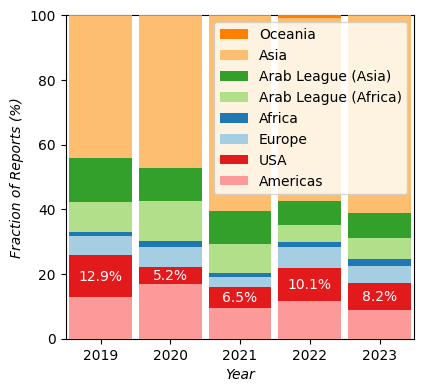

In [6]:
fig, ax = plt.subplots()
plot(c2, ax, COLORS2)


In [7]:
usa_adjusted = country_data.reports_per_capita.loc['USA']['reports_per_capita'] * 100_000

cont_adjusted = (
    country_data
    .reports_per_capita[['reports', 'population', 'continent']]
    .groupby(['continent', 'year'])
    .sum(numeric_only=True)
)
cont_adjusted = (
    (cont_adjusted['reports'] / cont_adjusted['population'] * 100_000)
    .to_frame()
    .drop('Antarctica')
    .unstack(level=0)
)
cont_adjusted.columns = cont_adjusted.columns.droplevel()
cont_adjusted.columns.name = None

cont_adjusted['USA'] = usa_adjusted
it.show(cont_adjusted)

,Africa,Americas,Asia,Europe,Oceania,USA
year,,,,,,
2019,134.3,429.1,211.4,134.4,106.4,655.0
2020,227.6,468.9,266.6,182.1,115.0,338.2
2021,215.5,455.4,441.1,120.1,222.7,566.7
2022,157.3,671.3,434.2,283.5,538.4,953.5
2023,215.3,594.4,522.0,261.7,246.7,877.7


In [8]:
from diaphanous import reports_per_country
reports_per_country()

,reports_per_capita
min,0.0000
max,0.0402


,iso3,year,reports,reports_pct,reports_per_capita,population,population_pct,online,online_pct,country,iso2,arab_league
rank,,,,,,,,,,,,
1,ARE,2019,"330,268",1.94420,0.03585,"9,211,657",0.118631,"9,133,361.0",0.056058,United Arab Emirates,AE,True
2,IRQ,2019,"1,026,809",6.04455,0.02470,"41,563,521",0.535271,"24,938,114.0",0.153062,Iraq,IR,True
3,LBY,2019,"150,848",0.88800,0.02296,"6,569,088",0.084599,⋯,⋯,Libya,LY,True
4,QAT,2019,"53,467",0.31475,0.01905,"2,807,235",0.036153,"2,797,495.0",0.017170,Qatar,QA,True
5,BHR,2019,"26,093",0.15360,0.01746,"1,494,189",0.019243,"1,489,735.0",0.009144,Bahrain,BH,True
6,DZA,2019,"700,535",4.12386,0.01640,"42,705,369",0.549976,"24,726,411.0",0.151763,Algeria,DZ,True
7,SYC,2019,"1,501",0.00884,0.01438,"104,373",0.001344,"78,290.0",0.000481,Seychelles,SC,False
8,SAU,2019,"514,832",3.03068,0.01437,"35,827,362",0.461398,"34,295,651.0",0.210496,Saudi Arabia,SA,True
9,KWT,2019,"63,492",0.37376,0.01430,"4,441,100",0.057194,"4,420,795.0",0.027133,Kuwait,KW,True


,iso3,year,reports,reports_pct,reports_per_capita,population,population_pct,online,online_pct,country,iso2,arab_league
rank,,,,,,,,,,,,
1,LBY,2020,"189,955",0.87331,0.02855,"6,653,942",0.084861,⋯,⋯,Libya,LY,True
2,DZA,2020,"1,102,939",5.07073,0.02538,"43,451,666",0.554163,"27,331,100.0",0.15111,Algeria,DZ,True
3,MCO,2020,886,0.00407,0.02400,"36,922",0.000471,⋯,⋯,Monaco,MC,False
4,ARE,2020,"216,874",0.99707,0.02335,"9,287,289",0.118446,"9,287,286.0",0.05135,United Arab Emirates,AE,True
5,IRQ,2020,"919,966",4.22952,0.02162,"42,556,984",0.542753,⋯,⋯,Iraq,IR,True
6,QAT,2020,"56,683",0.26060,0.02053,"2,760,385",0.035205,"2,750,807.0",0.01521,Qatar,QA,True
7,BTN,2020,"15,379",0.07070,0.01991,"772,506",0.009852,"413,294.0",0.00228,Bhutan,BT,False
8,MAR,2020,"705,863",3.24519,0.01924,"36,688,772",0.467912,"30,862,724.0",0.17063,Morocco,MA,True
9,KWT,2020,"68,582",0.31530,0.01573,"4,360,445",0.055611,"4,321,463.0",0.02389,Kuwait,KW,True


,iso3,year,reports,reports_pct,reports_per_capita,population,population_pct,online,online_pct,country,iso2,arab_league
rank,,,,,,,,,,,,
1,LBY,2021,"270,811",0.921199,0.04021,"6,735,277",0.0851565,⋯,⋯,Libya,LY,True
2,ARE,2021,"327,820",1.115122,0.03500,"9,365,145",0.1184068,⋯,⋯,United Arab Emirates,AE,True
3,IRQ,2021,"1,220,470",4.151586,0.02804,"43,533,593",0.5504106,⋯,⋯,Iraq,IR,True
4,PHL,2021,"3,188,793",10.847090,0.02800,"113,880,328",1.4398291,⋯,⋯,Philippines,PH,False
5,QAT,2021,"73,536",0.250142,0.02735,"2,688,235",0.0339883,⋯,⋯,Qatar,QA,True
6,DZA,2021,"1,171,653",3.985529,0.02652,"44,177,969",0.5585576,⋯,⋯,Algeria,DZ,True
7,KHM,2021,"395,793",1.346341,0.02386,"16,589,024",0.2097409,⋯,⋯,Cambodia,KH,False
8,BHR,2021,"32,346",0.110029,0.02211,"1,463,266",0.0185006,⋯,⋯,Bahrain,BH,True
9,BLZ,2021,"8,297",0.028223,0.02074,"400,031",0.0050577,⋯,⋯,Belize,BZ,False


,iso3,year,reports,reports_pct,reports_per_capita,population,population_pct,online,online_pct,country,iso2,arab_league
rank,,,,,,,,,,,,
1,ARE,2022,"265,307",0.827558,0.02810,"9,441,129",0.1183825,⋯,⋯,United Arab Emirates,AE,True
2,LBY,2022,"163,336",0.509485,0.02398,"6,812,341",0.0854201,⋯,⋯,Libya,LY,True
3,QAT,2022,"61,167",0.190795,0.02270,"2,695,122",0.0337942,⋯,⋯,Qatar,QA,True
4,PHL,2022,"2,576,182",8.035746,0.02229,"115,559,009",1.4489968,⋯,⋯,Philippines,PH,False
5,IRQ,2022,"905,883",2.825672,0.02036,"44,496,122",0.5579378,⋯,⋯,Iraq,IR,True
6,BHR,2022,"25,896",0.080776,0.01759,"1,472,233",0.0184604,⋯,⋯,Bahrain,BH,True
7,SAU,2022,"602,745",1.880110,0.01655,"36,408,820",0.4565309,⋯,⋯,Saudi Arabia,SA,True
8,DZA,2022,"731,167",2.280690,0.01628,"44,903,225",0.5630425,⋯,⋯,Algeria,DZ,True
9,BLZ,2022,"6,103",0.019037,0.01506,"405,273",0.0050817,⋯,⋯,Belize,BZ,False


,iso3,year,reports,reports_pct,reports_per_capita,population,population_pct,online,online_pct,country,iso2,arab_league
rank,,,,,,,,,,,,
1,ARE,2023,"295,661",0.816509,0.03107,"9,516,871",0.118291,⋯,⋯,United Arab Emirates,AE,True
2,LBY,2023,"206,430",0.570085,0.02997,"6,888,388",0.085620,⋯,⋯,Libya,LY,True
3,QAT,2023,"66,272",0.183019,0.02440,"2,716,391",0.033764,⋯,⋯,Qatar,QA,True
4,PHL,2023,"2,740,905",7.569393,0.02336,"117,337,368",1.458457,⋯,⋯,Philippines,PH,False
5,MNG,2023,"80,203",0.221492,0.02327,"3,447,157",0.042847,⋯,⋯,Mongolia,MN,False
6,SAU,2023,"833,909",2.302956,0.02257,"36,947,025",0.459237,⋯,⋯,Saudi Arabia,SA,True
7,OMN,2023,"99,862",0.275783,0.02150,"4,644,384",0.057728,⋯,⋯,Oman,OM,True
8,BHR,2023,"27,503",0.075953,0.01851,"1,485,510",0.018464,⋯,⋯,Bahrain,BH,True
9,KGZ,2023,"113,762",0.314170,0.01689,"6,735,348",0.083718,⋯,⋯,Kyrgyzstan,KG,False


index,,:,int64,(no nulls)
column,iso3,:,object,(no nulls)
column,year,:,category,(no nulls)
column,reports,:,int64,(no nulls)
column,reports_pct,:,float64,(no nulls)
column,reports_per_capita,:,float64,(no nulls)
column,population,:,int64,(no nulls)
column,population_pct,:,float64,(no nulls)
column,online,:,float64,(877 nulls)
column,online_pct,:,float64,(877 nulls)
column,country,:,object,(no nulls)
